In [1]:
import preprocessing # custom functions
import os
import h5py
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cd = os.getcwd()
data_directory = os.path.join(cd, '..', 'Data')

# Part 1: Create h5py file
with h5py.File(os.path.join(data_directory, 'data.h5'), 'w') as hdf_file:
    text_dataset = hdf_file.create_dataset('article_text', shape=(0,), maxshape=(None,), dtype=h5py.special_dtype(vlen=str))
    news_org_dataset = hdf_file.create_dataset('news_org', shape=(0,), maxshape=(None,), dtype=h5py.special_dtype(vlen=str))
    orientation_dataset = hdf_file.create_dataset('political_orientation', shape=(0,), maxshape=(None,), dtype=h5py.special_dtype(vlen=str))
    
    # Iterate over files
    for root, dirs, files in os.walk(os.path.join(data_directory, 'NELA_2017-2022')):
        for article in files:
            try:
                if article.endswith('.txt'):
                    article_path = os.path.join(root, article)
                    with open(article_path, 'r') as f:
                        article_text = f.read()
                    # Collect news organization name
                    news_org = str(preprocessing.get_news_org(article))
                    # Determine political orientation of news org
                    political_orientation = str(preprocessing.get_orientation_label(article))
                    # Append data to hdf5 datasets
                    text_dataset.resize((len(text_dataset) + 1, ))
                    text_dataset[-1] = article_text
                    news_org_dataset.resize((len(news_org_dataset) + 1, ))
                    news_org_dataset[-1] = news_org
                    orientation_dataset.resize((len(orientation_dataset) + 1, ))
                    orientation_dataset[-1] = political_orientation
            except Exception as e:
                print(f"Error processing file {article}: {str(e)}")
                
# Part 2: Split data

with h5py.File(os.path.join(data_directory, 'data.h5'), 'r') as hdf_file:
    article_text = np.array(hdf_file['article_text'])
    political_orientation = np.array(hdf_file['political_orientation'])

# Split data into training/validation sets

# X_train, X_test, y_train, y_test 

# Part 3: Train CNN/SVM/GBM on input text & political orientation labels



Error processing file RT--2017-09-15--St Louis braces for violence after ex-cop is acquitted of murdering black man.txt: 'Political orientation label not found for org: rt'
Error processing file RT--2017-09-12--Stay inside lock doors Active shooter search closes schools in Kentucky.txt: 'Political orientation label not found for org: rt'
Error processing file RT--2017-10-08--Intentional HIV infection no longer a felony in California.txt: 'Political orientation label not found for org: rt'
Error processing file RT--2017-10-13--Et tu Pikachu CNN claim Russia used Pokemon Go to meddle in US elections mocked online.txt: 'Political orientation label not found for org: rt'
Error processing file RT--2017-10-20--State Department admits Al-Nusra affiliate using chemical weapons in Syria.txt: 'Political orientation label not found for org: rt'
Error processing file RT--2017-08-31--FDA approves 1st living drug to treat cancer in the US.txt: 'Political orientation label not found for org: rt'
Erro

In [3]:
# Represent data as DataFrame
df = pd.DataFrame({'text': article_text, 'label': political_orientation})
df['text'] = df['text'].apply(lambda x: x.decode('utf-8'))
df['label'] = df['label'].apply(lambda x: x.decode('utf-8'))
df.tail()

,text,label
2359,It’s been discussed for decades and on Friday ...,right-center
2360,New York hospitals are making people sick at a...,right-center
2361,WASHINGTON – White House Chief of Staff Reince...,left-center
2362,WASHINGTON — The Justice Department asked the ...,left-center
2363,"WASHINGTON — Sergey Kislyak, Russia's ambassad...",left-center


In [4]:
# Create new column for word count of each article
df['wc'] = df['text'].apply(lambda x: len(x.split()))

# Calculate average wc per article
df['wc'].agg('mean')

534.8510998307953

Text(0.5, 1.0, 'The distribution of labels')

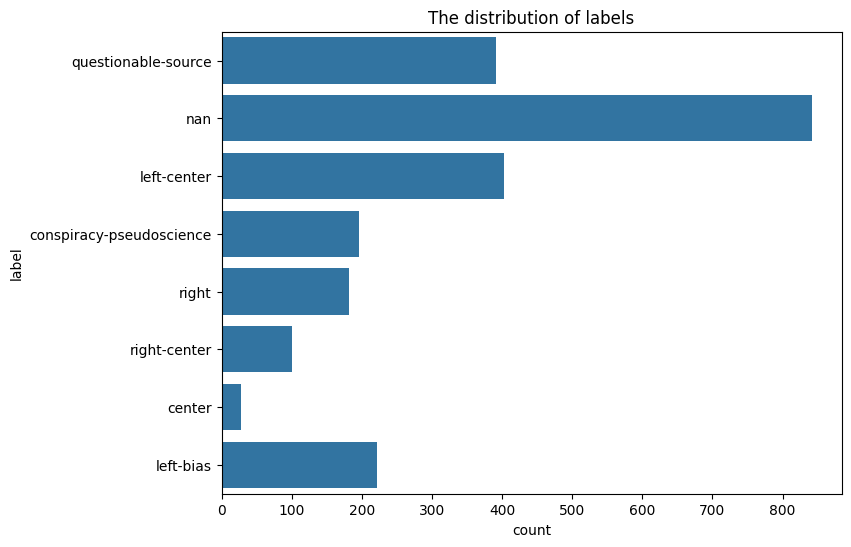

In [5]:
# Plot the distribution of labels
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('The distribution of labels')

In [6]:
# Let's get rid of all the NAN values
df = df[df['label'] != 'nan']

In [7]:
# Let's create a column with preprocessed text
df['text_tokenized'] = df['text'].apply(preprocessing.preprocess_text)

# Training

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [9]:
# Count max number of words in all articles
df['wc'].agg('max')

6536

In [10]:
df.drop('wc', axis=1, inplace=True)

In [12]:
# Encode labels

label_encoder = LabelEncoder()
df['labels_encoded'] = label_encoder.fit_transform(df['label'])

# Tokenize article text
max_words = 7000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text_tokenized']) 

# Convert text to padded seqs
X = tokenizer.texts_to_sequences(df['text_tokenized']) 
X = pad_sequences(X)

# we feed X into the lstm

In [13]:
df['labels_encoded'].unique()

array([4, 3, 1, 5, 6, 0, 2])

# Train

In [ ]:
# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, df['labels_encoded'], test_size=0.2, random_state=21)

# Construct LSTM
embedding_size = 100
lstm_out = 64

lstm_model = Sequential()
lstm_model.add(Embedding(max_words, embedding_size))
lstm_model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(7, activation='softmax')) # given that there are 7 unique classifications
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Part 3: Train LSTM model on input text & political orientation labels

batch_size = 32
epochs = 5
history = lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

# BERT

In [31]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW # We additionally tokenize with BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

# Tokenize text and convert to a tensor
input_ids = [tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True) for text in df['text']]
input_ids_tensors = [torch.tensor(seq) for seq in input_ids]

# We need to pad the seqs because they're currently of different lengths
input_ids_padded = pad_sequence(input_ids_tensors, batch_first=True, padding_value=0)

# Create attention masks
attention_masks = (input_ids_padded > 0).long()

# Get labels
labels = torch.tensor(df['labels_encoded'])

/Users/akilhuang/Library/Python/3.11/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
